<b>FINAL PROJECT: Investigating student performance over the past five years in a fully asynchronous introduction to programming course taught by Professor David Arnow at Brooklyn College.

First, we have to import the raw data of Common_Submissions and clean it up. The raw data has multiple columns: submission_id, date, semester, user_id, section_id, is_correct, is_compilererror, exercise_ssn, and exercise_type. (Note: I aggregated and pre cleaned this data somewhat from a larger SQL database for this project, so this isn't the rawest data but for the purpose of keeping this project short and straightforward this will do)

In [91]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# RELATIONAL dataset
path = 'Common_Submissions.csv' 
Common_Submissions = pd.read_csv(path)
Common_Submissions.head()

,submission_id,date,Sem,user_id,section_id,is_correct,is_compiler_error,exercise_type
0,138662182,1/31/19 01:24,Spring 2019,3,26782,False,False,common
1,138662186,1/31/19 01:24,Spring 2019,3,26782,True,False,common
2,138662208,1/31/19 01:28,Spring 2019,3,26782,False,True,common
3,138662212,1/31/19 01:28,Spring 2019,3,26782,True,False,common
4,138662213,1/31/19 01:28,Spring 2019,3,26782,True,False,common


Great! We have the dataset imported. However, we still need the actual exercise_id associated with each submission so we will scrape this from a web page with submission_id's and exercise_ssn's. We will be using Beautiful Soup, an html parser, to load our data into a data frame and save it to a CSV.

In [92]:
import requests
from bs4 import BeautifulSoup

# Fetch Webpage
url = 'https://k-kobi.github.io/data/'  
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract
raw_data = soup.get_text()
lines = raw_data.strip().split(' ')
header = lines[0].split(',')
d = [line.split(',') for line in lines[1:]]

# Put in DF and export
df = pd.DataFrame(d, columns=header)
df.to_csv('exercises.csv', index = False)

Now, lets merge the two sets and create a new CSV - Clean_Data

In [93]:
common_submissions = pd.read_csv('Common_Submissions.csv')
parsed_exercises = pd.read_csv('exercises.csv')
merged_data = pd.merge(common_submissions, parsed_exercises, on='submission_id', how='inner')
merged_data.to_csv('Clean_Data.csv', index=False)
merged_data.head()

,submission_id,date,Sem,user_id,section_id,is_correct,is_compiler_error,exercise_type,exercise_ssn
0,138662182,1/31/19 01:24,Spring 2019,3,26782,False,False,common,00001-20503
1,138662186,1/31/19 01:24,Spring 2019,3,26782,True,False,common,00001-20503
2,138662208,1/31/19 01:28,Spring 2019,3,26782,False,True,common,00001-20504
3,138662212,1/31/19 01:28,Spring 2019,3,26782,True,False,common,00001-20504
4,138662213,1/31/19 01:28,Spring 2019,3,26782,True,False,common,00001-20504


Great! Now we have a clean dataset! Let's now investigate the correlation between the average # of submissions per student on each exercise and the % of students who attempted but gave up on answering that exercise.

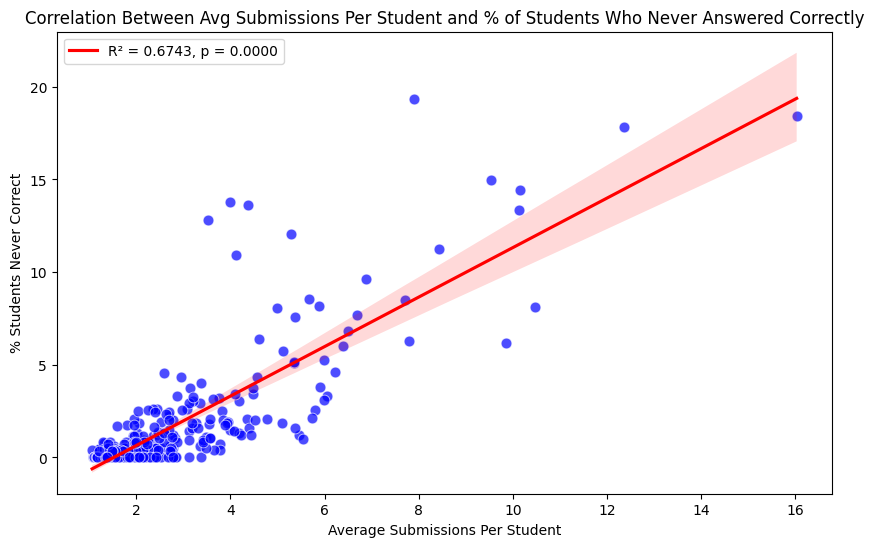

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

data = merged_data

# Calculate the % of students who never answered correctly for each exercise
never_correct = data.groupby(['exercise_ssn', 'user_id'])['is_correct'].any().groupby('exercise_ssn').apply(lambda x: 100 * (~x).mean()).reset_index(name='Percent Never Correct')

# Calculate the average submissions per student for each exercise
avg_submissions = data.groupby(['exercise_ssn', 'user_id'])['is_correct'].count().groupby('exercise_ssn').mean().reset_index(name='Avg Submissions Per Student')

# Merge
exercise_stats = pd.merge(never_correct, avg_submissions, on='exercise_ssn')

# Plot scatter plot with regression line
slope, intercept, r_value, p_value, std_err = linregress(exercise_stats['Avg Submissions Per Student'], exercise_stats['Percent Never Correct'])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=exercise_stats, x='Avg Submissions Per Student', y='Percent Never Correct', color='blue', s=60, alpha=0.7)
sns.regplot(data = exercise_stats, x= 'Avg Submissions Per Student', y = 'Percent Never Correct',  color='red', scatter =False, label=f'R² = {r_value**2:.4f}, p = {p_value:.4f}')
plt.title('Correlation Between Avg Submissions Per Student and % of Students Who Never Answered Correctly')
plt.xlabel('Average Submissions Per Student')
plt.ylabel('% Students Never Correct')
plt.legend()
plt.show()

Seems that exercises that had a greater average number of submissions by student also tended to be the exercises where students gave up the most. Now, these are both very interesting measures of difficulty of a particular exercise. I am now interested in what those particular exercises are and what their topics are. Let's find the top 25 exercises that had the highest number of average submissions and the top 25 exercises that had the highest % of students who gave up and see what is in common to find the most difficult exercises.

In [95]:
# Get top 25 for each metric
top_25_avg_submissions = avg_submissions.nlargest(25, 'Avg Submissions Per Student')
top_25_never_correct = never_correct.nlargest(25, 'Percent Never Correct')

# Merge to find common
hardest_exercises = pd.merge(top_25_avg_submissions, top_25_never_correct, on='exercise_ssn')

# Display common
print("Hardest exercises:")
print(hardest_exercises)

Hardest exercises:
    exercise_ssn  Avg Submissions Per Student  Percent Never Correct
0   317682-00495                    16.027933              18.435754
1   317682-00473                    12.351598              17.808219
2   317682-00490                    10.464865               8.108108
3    00001-20882                    10.149733              14.438503
4   317682-00488                    10.122093              13.372093
5    00001-20884                     9.860825               6.185567
6    00001-20934                     9.529412              14.973262
7   317682-00480                     8.429577              11.267606
8   317682-00496                     7.895161              19.354839
9    00001-20845                     7.786164               6.289308
10  317682-00363                     7.712551               8.502024
11   00001-21217                     6.879518               9.638554
12   00001-20937                     6.692308               7.692308
13  317682-0047

Great, now we have an idea of which exercises were the most challenging via these two metrics. I am now interested in the difference in the number of attempts to successfully complete and number of attempts before giving up on THIS SPECIFIC SUBSET of "difficult" exercises. The central hypothesis is that students who are attempting the problem more are struggling more and may give up more. I will be using a welch's t-test to investigate statistical significance.

In [96]:
from scipy.stats import ttest_ind

# Filter merged_data for hardest exercises
hardest_exercise_ssns = hardest_exercises['exercise_ssn']
filtered_data = merged_data[merged_data['exercise_ssn'].isin(hardest_exercise_ssns)]

# Group submissions into completed and gave up groups
completed_submissions = filtered_data.groupby(['user_id', 'exercise_ssn']).filter(lambda x: x['is_correct'].any())
gave_up_submissions = filtered_data.groupby(['user_id', 'exercise_ssn']).filter(lambda x: not x['is_correct'].any())

# Calculate # of attempts for each user per exercise
attempts_completed = completed_submissions.groupby(['user_id', 'exercise_ssn']).size().reset_index(name='attempts')
attempts_gave_up = gave_up_submissions.groupby(['user_id', 'exercise_ssn']).size().reset_index(name='attempts')

Our data WILL have outliers and I would like to remove these for this analysis. Many students over submit meaninglessly and I want to encapsulate the true nature of the majority of students. What method can we use? Let's first find out if our data is normally distributed using a Shapiro-Wilk Test.

In [97]:
from scipy.stats import shapiro

# Completed group
stat, p_completed = shapiro(attempts_completed['attempts'])
print(f"Shapiro-Wilk Test (Completed): p-value = {p_completed}")

# Gave up group
stat, p_gave_up = shapiro(attempts_gave_up['attempts'])
print(f"Shapiro-Wilk Test (Gave Up): p-value = {p_gave_up}")

Shapiro-Wilk Test (Completed): p-value = 1.429739949439894e-63
Shapiro-Wilk Test (Gave Up): p-value = 3.659842761090945e-23


This data is VERY not normally distributed in both groups. Let's use the IQR method to remove outliers.

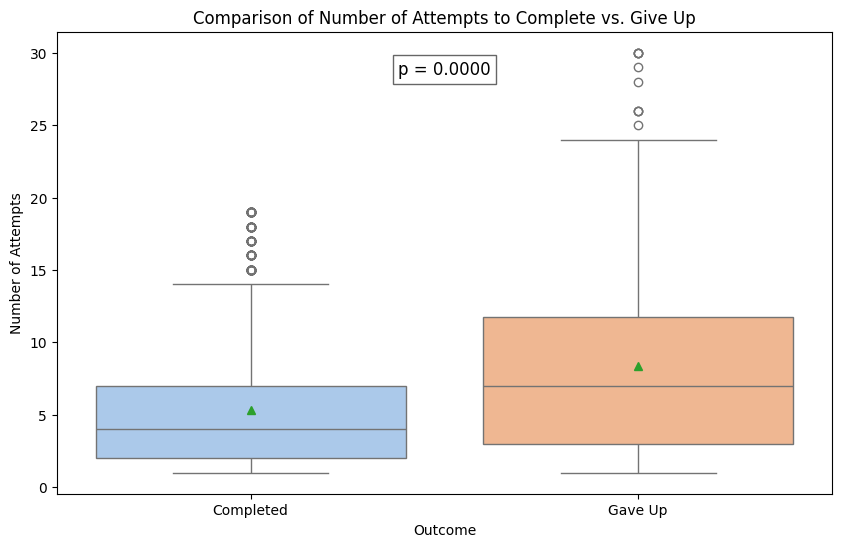

In [98]:
# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25) 
    Q3 = df[column].quantile(0.75) 
    IQR = Q3 - Q1  

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to exclude outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

filtered_attempts_completed = remove_outliers(attempts_completed, 'attempts').assign(Outcome='Completed')
filtered_attempts_gave_up = remove_outliers(attempts_gave_up, 'attempts').assign(Outcome='Gave Up')

# Add labels for outcomes
filtered_attempts_completed['Outcome'] = 'Completed'
filtered_attempts_gave_up['Outcome'] = 'Gave Up'

# Combine
combined_attempts = pd.concat([filtered_attempts_completed, filtered_attempts_gave_up])

# Perform Welch's t-test
t_stat, p_value = ttest_ind(filtered_attempts_completed['attempts'], filtered_attempts_gave_up['attempts'], equal_var=False)

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_attempts, x='Outcome', y='attempts', palette = 'pastel', showmeans= True)
plt.title('Comparison of Number of Attempts to Complete vs. Give Up')
plt.xlabel('Outcome')
plt.ylabel('Number of Attempts')
p_value_text_attempts = f"p = {p_value:.4f}"
plt.text(0.5, combined_attempts['attempts'].max() * 0.95, 
         p_value_text_attempts, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

plt.show()

It seems that in these challenging problems, students who are giving up tended to have a higher number of attempts on the problem (p < 0.0001). These data VERY BROADLY point to the conclusion that the # of attempts on exercises are measures of perceived difficulty, and the combined dataset has identified which specific exercise_ssn's students tended to struggle with the most! This data is incredibly informative and we know where to target improvements to the introductory programming course in the future!